# Problem Set 5

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
import requests
from IPython.display import display
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
sns.set_style('darkgrid')


In [3]:
def fetch_and_cache(data_url, file, data_dir="data", force = False):
    """
    (Credit: John DeNero)
    Download and cache a url and return the file object.

    Dependent: from pathlib import Path
                import requests
    
    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded 
    
    return: The pathlib.Path to the file.
    """
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end = ' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
    else:
        import time
        created = time.ctime(file_path.stat().st_ctime)
        print("Using cached version downloaded at", created)
    return file_path

data_urls = [
    r"https://bcourses.berkeley.edu/files/74659744/download?download_frd=1",
    r"https://bcourses.berkeley.edu/files/74659745/download?download_frd=1"
]
file_names = [
    "bydegree.csv",
    "twins142.csv"
]

files = []
for url, name in zip(data_urls, file_names):
    files.append(fetch_and_cache(url, name))

degree_df = pd.read_csv(files[0])
twins_df = pd.read_csv(files[1])
display(degree_df.head())
display(twins_df.head())

Using cached version downloaded at Tue Mar  5 14:18:49 2019
Using cached version downloaded at Tue Mar  5 14:18:52 2019


,ST,AGEP,race,hispanic,female,logwage,logearn,field,mfield
0,1,33,1,0,0,6.551080,10.239960,62,6
1,1,26,2,0,1,6.745236,10.434116,36,7
2,1,27,2,0,0,6.725434,10.596635,61,9
3,1,31,1,0,1,7.236259,10.819778,61,9
4,1,33,4,0,0,7.362011,11.050890,21,2


,famid,age,daded_a,t,lw,married,omarried,educ,oeduc,female,ofemale,exp,oexp
0,2,33.25119,12.0,1,2.479523,0,0,16.0,16.0,1,1,11.25119,11.25119
1,2,33.25119,12.0,2,2.220177,0,0,16.0,16.0,1,1,11.25119,11.25119
2,4,43.57014,12.0,1,2.949527,0,1,18.0,12.0,1,1,19.57014,25.57014
3,4,43.57014,12.0,2,2.228209,1,0,12.0,18.0,1,1,25.57014,19.57014
4,6,30.96782,12.0,1,2.850934,1,1,12.0,12.0,0,0,12.96782,12.96782


In [4]:
race_key = {
    1:"white",
    2:"black",
    3:"asian",
    4:"other"
}
gender_key = {
    0:"male",
    1:"female"
}
mfield_key = {
    1:"COMM/JOURN",
    2:"COMPSCI/STAT",
    3:"EDUCATION",
    4:"ENGINEERING",
    5:"SOCSCI/PSYCH",
    6:"BUSINESS",
    7:"NATSCI",
    8:"HUMANITIES",
    9:"MEDICINE",
    10:"OTHER"
}


## Question 1:

In [5]:
degree_df['race'] = degree_df['race'].map(race_key)

In [6]:
def label_race(row):
    try:
        if row['race group']:
            return row['race group']
    except KeyError:
            pass
    if row['hispanic'] == 1:
        return "hispanic"
    elif row['race'] == 'other':
        return "other non-hispanic"
    else:
        return row['race']
    
degree_df['race group'] = degree_df.apply(lambda row: label_race(row) ,axis = 1)
degree_df['field group'] = degree_df['mfield'].map(mfield_key)
display(degree_df.head())

,ST,AGEP,race,hispanic,female,logwage,logearn,field,mfield,race group,field group
0,1,33,white,0,0,6.551080,10.239960,62,6,white,BUSINESS
1,1,26,black,0,1,6.745236,10.434116,36,7,black,NATSCI
2,1,27,black,0,0,6.725434,10.596635,61,9,black,MEDICINE
3,1,31,white,0,1,7.236259,10.819778,61,9,white,MEDICINE
4,1,33,other,0,0,7.362011,11.050890,21,2,other non-hispanic,COMPSCI/STAT


In [7]:
female_prop = degree_df[
    ['female', 'race group']].groupby('race group').agg(
    lambda g: sum(g)/len(g)).reset_index()
female_prop['male'] = female_prop['female'].apply(lambda row: 1 - row)

female_prop = pd.melt(female_prop, id_vars=['race group'], value_vars=['female', 'male']).rename(
    {'variable':'gender', 'value': 'proportion'}, axis = 1)

display(female_prop.head())

,race group,gender,proportion
0,asian,female,0.470035
1,black,female,0.582350
2,hispanic,female,0.489915
3,other non-hispanic,female,0.481944
4,white,female,0.444436


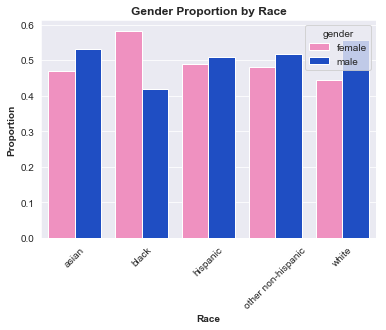

In [8]:
sns.barplot(x = 'race group', y = 'proportion', hue = 'gender', 
            palette = {'female': 'xkcd:pink', 'male':'xkcd:blue'}, data = female_prop)
plt.xlabel("Race", fontweight = 'bold')
plt.xticks(rotation=45)
plt.ylabel("Proportion", fontweight = 'bold')
plt.title("Gender Proportion by Race", fontweight = 'bold', fontsize = '12')
plt.show()

## Question 2:

### a)

In [9]:
field_prop = degree_df[
    ['female', 'field group']].groupby('field group').agg(
    lambda g: sum(g)/len(g)).reset_index()
field_prop['male'] = field_prop['female'].apply(lambda row: 1 - row)

field_prop = pd.melt(field_prop, id_vars=['field group'], value_vars=['female', 'male']).rename(
    {'variable':'gender', 'value': 'proportion'}, axis = 1)
display(field_prop.head())


,field group,gender,proportion
0,BUSINESS,female,0.443498
1,COMM/JOURN,female,0.541151
2,COMPSCI/STAT,female,0.229054
3,EDUCATION,female,0.716545
4,ENGINEERING,female,0.137484


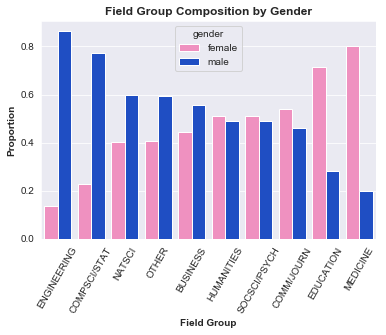

In [10]:
order = ['ENGINEERING', 'COMPSCI/STAT','NATSCI', 'OTHER','BUSINESS', 'HUMANITIES', 
         'SOCSCI/PSYCH', 'COMM/JOURN','EDUCATION','MEDICINE',]
sns.barplot(x = 'field group', y = 'proportion', hue = 'gender', order = order, 
            palette = {'female': 'xkcd:pink', 'male':'xkcd:blue'}, data = field_prop)
plt.xticks(rotation=60)
plt.xlabel("Field Group", fontweight = 'bold')
plt.ylabel("Proportion", fontweight = 'bold')
plt.title("Field Group Composition by Gender", fontweight = 'bold', fontsize = '12')
plt.show()

In [11]:
field_mean_logwage = degree_df[
    ['female', 'field group', 'logwage']
].groupby(['female', 'field group']).mean().reset_index()

field_mean_logwage['female'] = field_mean_logwage['female'].map(gender_key)
field_mean_logwage.rename({'female':'gender'},axis = 1, inplace = True)

display(field_mean_logwage.head())

,gender,field group,logwage
0,male,BUSINESS,7.229572
1,male,COMM/JOURN,7.108538
2,male,COMPSCI/STAT,7.340410
3,male,EDUCATION,6.888829
4,male,ENGINEERING,7.397082


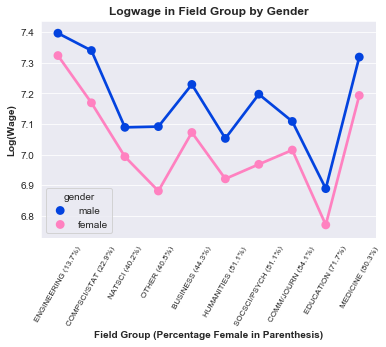

In [12]:
ax = sns.pointplot(x = 'field group', y = 'logwage', hue = 'gender', order = order, 
              palette = {'female': 'xkcd:pink', 'male':'xkcd:blue'},
              join = True ,data = field_mean_logwage)

plt.xticks(rotation = 60)

new_labels = []
for t in ax.get_xticklabels():
    t_text = t.get_text()
    new_labels.append("{} ({}%)".format(t_text, 
                                     round(field_prop.loc[
                                         ((field_prop['field group'] == t_text) & (field_prop['gender'] == 'female'))
                                     ].proportion.get_values()[0] * 100, 1)
                                    ))
ax.set_xticklabels(new_labels, fontsize = 8)
plt.xlabel("Field Group (Percentage Female in Parenthesis)", fontweight = 'bold')
plt.ylabel("Log(Wage)", fontweight = 'bold')
plt.title("Logwage in Field Group by Gender", fontweight = 'bold', fontsize = 12)

plt.show()

In [13]:
gender_prop = degree_df[['field group', 'female']].groupby('field group').agg(
    lambda g: sum(g['female'])/sum(degree_df['female'])
)

gender_prop['male'] = degree_df[['field group', 'female']].groupby('field group').agg(
    lambda g: sum(g['female'] == 0)/sum(degree_df['female'] == 0)
)
gender_prop.reset_index(inplace = True)
gender_prop = pd.melt(gender_prop, id_vars=['field group'], 
                      value_vars=['female', 'male']).rename({"variable":"gender", "value":"proportion"}, axis = 1)
display(gender_prop.head())

,field group,gender,proportion
0,BUSINESS,female,0.260258
1,COMM/JOURN,female,0.070663
2,COMPSCI/STAT,female,0.030315
3,EDUCATION,female,0.106942
4,ENGINEERING,female,0.024072


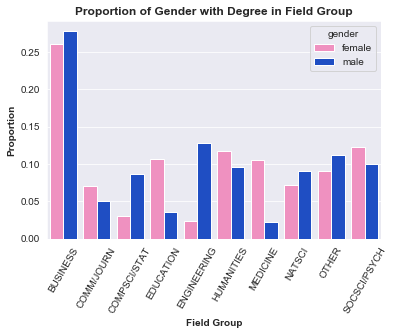

In [14]:
sns.barplot(x = 'field group', y = 'proportion', hue = 'gender',palette = {'female': 'xkcd:pink', 'male':'xkcd:blue'},
            data = gender_prop)
plt.xticks(rotation = 60)
plt.xlabel("Field Group", fontweight = 'bold')
plt.ylabel("Proportion", fontweight = 'bold')
plt.title("Proportion of Gender with Degree in Field Group", fontweight = 'bold', fontsize = 12)
plt.show()

### b)

Weighted Average Mean log(wage) for genders across categories:

In [15]:
field_mean_logwage = field_mean_logwage.merge(gender_prop, on = ['field group', 'gender'])
display(field_mean_logwage.head())

,gender,field group,logwage,proportion
0,male,BUSINESS,7.229572,0.277531
1,male,COMM/JOURN,7.108538,0.050919
2,male,COMPSCI/STAT,7.340410,0.086712
3,male,EDUCATION,6.888829,0.035952
4,male,ENGINEERING,7.397082,0.128339


In [16]:
wavgs = field_mean_logwage.set_index(['gender', 'field group']).apply(
    lambda row: row['logwage']*row['proportion'], axis = 1).reset_index(
    ).groupby('gender').sum().values

wavgs_female, wavgs_male = wavgs[0][0], wavgs[1][0]

counterf_wavg_female = field_mean_logwage.pivot(index = 'field group', columns = 'gender').apply(
        lambda row:row[("logwage", "female")]*row[('proportion', 'male')], axis = 1
    ).sum()

true_diff = abs(wavgs_female - wavgs_male)

counterf_diff = abs(wavgs_male - counterf_wavg_female)

print("Weighted average logwage of females is {} \nWeighted average logwage of males is {}".format(wavgs_female,wavgs_male))
print("The logwage gap is: {}\n".format(true_diff))

print("Counterfactual average logwage of females from male distribution is: {}".format(counterf_wavg_female))
print("The counter factual logwage gap is: {}\n".format(counterf_diff))

print("{}% of counterfactual logwage gap is explained by the distribution of jobs".format(
    (abs(true_diff - counterf_diff)/true_diff)*100))

Weighted average logwage of females is 7.004288245649157 
Weighted average logwage of males is 7.19593965362868
The logwage gap is: 0.1916514079795233

Counterfactual average logwage of females from male distribution is: 7.048425379285004
The counter factual logwage gap is: 0.14751427434367592

23.029903146113664% of counterfactual logwage gap is explained by the distribution of jobs


### c)

In [17]:
counterf_wavg_male = field_mean_logwage.pivot(index = 'field group', columns = 'gender').apply(
        lambda row:row[("logwage", "male")]*row[('proportion', 'female')], axis = 1
    ).sum()
counterf_diff_m = abs(counterf_wavg_male - wavgs_female)

print("The counter factual logwage gap is: {}".format(counterf_diff_m))
print("{}% of counterfactual logwage gap is explained by the distribution of jobs".format(
    (abs(true_diff - counterf_diff_m)/true_diff)*100 ))

The counter factual logwage gap is: 0.14991611188693454
21.77667074433802% of counterfactual logwage gap is explained by the distribution of jobs


The counterfactuals have different results since the weights are skewed by the sample. The two groups aren't perfectly parallel and thus slightly violate a parallel trends assumption made when creating the counterfactuals. 

## 3)

### e)

In [18]:
degree_df['male'] = degree_df['female'].apply(lambda x: abs(x-1))
degree_df.rename( 
    {"field group":"field_group", "race group":"race_group"}
    , axis = 1, inplace = True)
def square(x):
    return x**2
model = """male ~ 1 + AGEP + square(AGEP) + field_group + race_group
+ AGEP*field_group"""
logit_reg = smf.logit(formula = model, data = degree_df).fit()
logit_reg.summary()

p_hat = logit_reg.predict(degree_df[
                        ['AGEP', 'field_group', 'race_group']])

w_hat = p_hat.apply(lambda x: x/(1-x))

Optimization terminated successfully.
         Current function value: 0.629133
         Iterations 6


### a)

In [19]:
degree_df['weights'] = w_hat
degree_df['weights*female'] = degree_df['female']*degree_df['weights']

gender_prop = degree_df[['field_group', 'female']].groupby('field_group').agg(
    lambda g: sum(g['female'])/sum(degree_df['female'])
)

gender_prop['male'] = degree_df[['field_group', 'female']].groupby('field_group').agg(
    lambda g: sum(g['female'] == 0)/sum(degree_df['female'] == 0)
)
gender_prop['weights*female'] = degree_df[['field_group', 'weights*female']].groupby('field_group').agg(
    lambda g: sum(g['weights*female'])/sum(degree_df['weights*female'])
)    
    
gender_prop.reset_index(inplace = True)

display(gender_prop)


,field_group,female,male,weights*female
0,BUSINESS,0.260258,0.277531,0.277418
1,COMM/JOURN,0.070663,0.050919,0.051390
2,COMPSCI/STAT,0.030315,0.086712,0.085356
3,EDUCATION,0.106942,0.035952,0.036310
4,ENGINEERING,0.024072,0.128339,0.126247
5,HUMANITIES,0.117658,0.095581,0.096482
6,MEDICINE,0.105389,0.021909,0.022116
7,NATSCI,0.071781,0.090619,0.090945
8,OTHER,0.090076,0.112396,0.112853
9,SOCSCI/PSYCH,0.122845,0.100042,0.100882


the weights\*female column is a close approximate to the male column for each category. 

### b)

In [20]:
model = 'logwage ~ female'

res = smf.ols(model, degree_df).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.028      
Dependent Variable: logwage          AIC:                119097.9843
Date:               2019-03-07 14:47 BIC:                119116.2991
No. Observations:   70079            Log-Likelihood:     -59547.    
Df Model:           1                F-statistic:        1996.      
Df Residuals:       70077            Prob (F-statistic): 0.00       
R-squared:          0.028            Scale:              0.32032    
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
Intercept       7.1959    0.0029  2474.6912  0.0000   7.1902   7.2016
female         -0.1917    0.0043   -44.6731  0.0000  -0.2001  -0.1832
--------------------------------------------------------------------
Omnibus:             10487.890      Durbin-Watson:         1.869    
Prob(Omnibus):       0.000          Jarque-Bera (JB):      75987.282
Skew:                -0.522         Prob(JB):              0.000    
Kurtosis:            7.994          Condition No.:         3        
====================================================================

"""

### c)

In [21]:
model = 'logwage ~ (weights*female)'

res = smf.ols(model, degree_df).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.055      
Dependent Variable: logwage          AIC:                117089.3636
Date:               2019-03-07 14:47 BIC:                117125.9931
No. Observations:   70079            Log-Likelihood:     -58541.    
Df Model:           3                F-statistic:        1365.      
Df Residuals:       70075            Prob (F-statistic): 0.00       
R-squared:          0.055            Scale:              0.31126    
--------------------------------------------------------------------
                    Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
Intercept           7.0792   0.0041 1706.5512 0.0000  7.0711  7.0874
weights             0.0550   0.0014   38.9168 0.0000  0.0522  0.0578
female             -0.1560   0.0063  -24.8720 0.0000 -0.1683 -0.1437
weights:female      0.0142   0.0033    4.2638 0.0000  0.0077  0.0207
--------------------------------------------------------------------
Omnibus:             10969.363      Durbin-Watson:         1.868    
Prob(Omnibus):       0.000          Jarque-Bera (JB):      88355.207
Skew:                -0.523         Prob(JB):              0.000    
Kurtosis:            8.401          Condition No.:         9        
====================================================================

"""

We see the female coefficient is reduced by about 25% from -.1917 to -.1560

### d)

In [22]:
model = 'logwage ~ female + AGEP + square(AGEP) + race_group + field_group'

res = smf.ols(model, degree_df).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
=================================================================================
Model:                   OLS                  Adj. R-squared:         0.134      
Dependent Variable:      logwage              AIC:                    110975.3346
Date:                    2019-03-07 14:47     BIC:                    111131.0101
No. Observations:        70079                Log-Likelihood:         -55471.    
Df Model:                16                   F-statistic:            680.3      
Df Residuals:            70062                Prob (F-statistic):     0.00       
R-squared:               0.134                Scale:                  0.28521    
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept                         4.5435   0.1318  34.4749 0.0000  4.2852  4.8018
race_group[T.black]              -0.1854   0.0107 -17.3143 0.0000 -0.2064 -0.1644
race_group[T.hispanic]           -0.1464   0.0099 -14.7115 0.0000 -0.1659 -0.1269
race_group[T.other non-hispanic] -0.0948   0.0157  -6.0527 0.0000 -0.1254 -0.0641
race_group[T.white]              -0.0277   0.0073  -3.8077 0.0001 -0.0419 -0.0134
field_group[T.COMM/JOURN]        -0.0711   0.0091  -7.7920 0.0000 -0.0890 -0.0532
field_group[T.COMPSCI/STAT]       0.1113   0.0091  12.1648 0.0000  0.0933  0.1292
field_group[T.EDUCATION]         -0.3175   0.0087 -36.4116 0.0000 -0.3346 -0.3004
field_group[T.ENGINEERING]        0.1754   0.0083  21.2250 0.0000  0.1592  0.1916
field_group[T.HUMANITIES]        -0.1578   0.0073 -21.5229 0.0000 -0.1722 -0.1434
field_group[T.MEDICINE]           0.0933   0.0092  10.0975 0.0000  0.0752  0.1114
field_group[T.NATSCI]            -0.1196   0.0081 -14.8456 0.0000 -0.1353 -0.1038
field_group[T.OTHER]             -0.1478   0.0074 -19.9171 0.0000 -0.1623 -0.1332
field_group[T.SOCSCI/PSYCH]      -0.0633   0.0072  -8.7758 0.0000 -0.0774 -0.0492
female                           -0.1257   0.0043 -29.2737 0.0000 -0.1341 -0.1173
AGEP                              0.1365   0.0080  16.9674 0.0000  0.1207  0.1522
square(AGEP)                     -0.0016   0.0001 -13.3116 0.0000 -0.0019 -0.0014
---------------------------------------------------------------------------------
Omnibus:                 14413.219          Durbin-Watson:             1.874     
Prob(Omnibus):           0.000              Jarque-Bera (JB):          131171.570
Skew:                    -0.733             Prob(JB):                  0.000     
Kurtosis:                9.540              Condition No.:             75352     
=================================================================================
* The condition number is large (8e+04). This might indicate             strong
multicollinearity or other numerical problems.
"""

The regression shows a female coefficient which is >25% lower than the unweighted regression.

# Part 2:

## 1)

In [23]:
model = "lw ~ educ + exp + square(exp) + married + female"

res = smf.ols(model, twins_df).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.311    
Dependent Variable: lw               AIC:                1590.7442
Date:               2019-03-07 14:47 BIC:                1620.6191
No. Observations:   1074             Log-Likelihood:     -789.37  
Df Model:           5                F-statistic:        98.02    
Df Residuals:       1068             Prob (F-statistic): 4.25e-85 
R-squared:          0.315            Scale:              0.25607  
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept      0.3455    0.1323    2.6114  0.0091   0.0859   0.6052
educ           0.1238    0.0081   15.3105  0.0000   0.1080   0.1397
exp            0.0523    0.0045   11.6779  0.0000   0.0435   0.0611
square(exp)   -0.0009    0.0001   -8.9849  0.0000  -0.0011  -0.0007
married        0.0693    0.0341    2.0320  0.0424   0.0024   0.1363
female        -0.3341    0.0314  -10.6451  0.0000  -0.3957  -0.2725
------------------------------------------------------------------
Omnibus:              79.843       Durbin-Watson:          1.532  
Prob(Omnibus):        0.000        Jarque-Bera (JB):       178.066
Skew:                 0.447        Prob(JB):               0.000  
Kurtosis:             4.783        Condition No.:          5941   
==================================================================
* The condition number is large (6e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

## 2)

In [24]:
female_twins = twins_df.loc[twins_df['female'] == 1]

male_twins = twins_df.loc[twins_df['female'] == 0]

print("Female Model:")
res = smf.ols(model, female_twins).fit()
print(res.summary2())

print("\nMale Model:") #but why male models?
res = smf.ols(model, male_twins).fit()
print(res.summary2())

Female Model:
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.298   
Dependent Variable: lw               AIC:                698.2342
Date:               2019-03-07 14:47 BIC:                719.9974
No. Observations:   574              Log-Likelihood:     -344.12 
Df Model:           4                F-statistic:        61.92   
Df Residuals:       569              Prob (F-statistic): 1.97e-43
R-squared:          0.303            Scale:              0.19591 
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.0427    0.0800  -0.5338  0.5937  -0.1997   0.1144
educ           0.1369    0.0100  13.7081  0.0000   0.1173   0.1566
exp            0.0529    0.0056   9.3912  0.0000   0.0419   0.0640
square(exp)   -0.0010    0.0001  -7.5664  0.0000  -0.0012  -0.0007
marrie

c:\users\mclev\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\regression\linear_model.py:1633: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\users\mclev\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
c:\users\mclev\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\mclev\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\mclev\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equ

## 3)

In [25]:
married_rate = twins_df[['famid','married']
                       ].groupby('famid').agg(lambda g: sum(g)/2
            ).reset_index().rename({"married":"avg_married"}, axis = 1)
twins_df = twins_df.merge(married_rate, on = 'famid')
display(married_rate.head())

,famid,avg_married
0,2,0.0
1,4,0.5
2,6,1.0
3,7,0.0
4,11,0.5


### a)

In [26]:
model = "married ~ avg_married - 1"

res = smf.ols(model, twins_df).fit()
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.863   
Dependent Variable: married          AIC:                124.8060
Date:               2019-03-07 14:47 BIC:                129.7851
No. Observations:   1074             Log-Likelihood:     -61.403 
Df Model:           1                F-statistic:        6765.   
Df Residuals:       1073             Prob (F-statistic): 0.00    
R-squared:          0.863            Scale:              0.065704
------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
avg_married      1.0000    0.0122  82.2510  0.0000  0.9761  1.0239
-----------------------------------------------------------------
Omnibus:              16.657       Durbin-Watson:          2.975 
Prob(Omnibus):        0.000        Jarque-Bera (JB):       29.253
Skew:                 0.000        Prob(JB):               0.000 
Kurtosis:             3.809        Condition No.:          1     
=================================================================

"""

Notice that the avg_married coefficient is 1.

### b) 

In [27]:
model = "lw ~ educ + exp + square(exp) + married + female + avg_married"

female_twins = twins_df.loc[twins_df['female'] == 1]

male_twins = twins_df.loc[twins_df['female'] == 0]

print("Female Model:")
res = smf.ols(model, female_twins).fit()
print(res.summary2())

print("\nMale Model:") #but why male models?
res = smf.ols(model, male_twins).fit()
print(res.summary2())

Female Model:
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.297   
Dependent Variable: lw               AIC:                700.1395
Date:               2019-03-07 14:47 BIC:                726.2552
No. Observations:   574              Log-Likelihood:     -344.07 
Df Model:           5                F-statistic:        49.47   
Df Residuals:       568              Prob (F-statistic): 1.58e-42
R-squared:          0.303            Scale:              0.19622 
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.0413    0.0801  -0.5155  0.6064  -0.1987   0.1161
educ           0.1368    0.0100  13.6603  0.0000   0.1171   0.1564
exp            0.0534    0.0058   9.1861  0.0000   0.0420   0.0648
square(exp)   -0.0010    0.0001  -7.4913  0.0000  -0.0012  -0.0007
marrie

After accounting for average number of marriages, we see the coefficient for female fall by about half which suggests that much of the difference between the two groups is bared by married women and unmarried women see less of a difference in wages. 